In [4]:
import os
os.chdir("/Users/melisande.croft/Library/CloudStorage/OneDrive-Htechnopole/Repos/kymograph-synthesis/src")

In [35]:
import numpy as np
from numpy.typing import NDArray
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.gridspec import GridSpec
from microsim import schema as ms
from microsim.util import ortho_plot

from kymograph_synthesis.dynamics.particle_simulator.motion_state_collection import (
    MotionStateCollection,
)
from kymograph_synthesis.dynamics.system_simulator import (
    create_particle_simulators,
    run_simulation,
)
from kymograph_synthesis.render.static_path import (
    LinearPath,
    QuadraticBezierPath,
    PiecewiseQuadraticBezierPath,
)
from kymograph_synthesis.render.fluorophore_distributions import (
    ParticleSystem,
    SimplexNoise,
)
from kymograph_synthesis.sample_kymograph import inter_pixel_interp

# --- simulation params
n_steps = 64
particle_density = 6

# retro_speed_mode = 0.2e-2
# retro_speed_var = 0.02e-2 ** 2
retro_speed_mode = 2.4e-2
retro_speed_var = 0.2e-2**2
antero_speed_mode = 1.6e-2
antero_speed_var = 0.1e-2**2
velocity_noise_std = 0.32e-2

intensity_mode = 300
intensity_var = 50**2

n_spatial_samples = 96

transition_matrix = {
    MotionStateCollection.ANTEROGRADE: {
        MotionStateCollection.ANTEROGRADE: 0.9,
        MotionStateCollection.STATIONARY: 0.1,
        MotionStateCollection.RETROGRADE: 0,
    },
    MotionStateCollection.STATIONARY: {
        MotionStateCollection.ANTEROGRADE: 0.5,
        MotionStateCollection.STATIONARY: 0.5,
        MotionStateCollection.RETROGRADE: 0,
    },
    MotionStateCollection.RETROGRADE: {
        MotionStateCollection.ANTEROGRADE: 0,
        MotionStateCollection.STATIONARY: 0,
        MotionStateCollection.RETROGRADE: 1,
    },
}

# --- generate particle properties from simulation
particles = create_particle_simulators(
    particle_density,
    antero_speed_mode,
    antero_speed_var,
    retro_speed_mode,
    retro_speed_var,
    intensity_mode=intensity_mode,
    intensity_var=intensity_var,
    intensity_half_life_mode=n_steps * 2,
    intensity_half_life_var=n_steps / 2,
    velocity_noise_std=velocity_noise_std,
    transition_matrix=transition_matrix,
    n_steps=n_steps,
)
particle_positions, particle_intensities = run_simulation(n_steps, particles)

In [36]:
particle_positions

array([[ 1.30860585,  0.7233205 ,  2.83559681, ...,  0.93225318,
         1.00428348, -1.05972183],
       [ 1.28241883,  0.73599416,  2.84817888, ...,  0.91057278,
         1.02544061, -1.08218384],
       [ 1.26001317,  0.75707077,  2.85883689, ...,  0.89166139,
         1.03786604, -1.1094614 ],
       ...,
       [-0.29817771,  1.50186327,  3.65463478, ..., -0.5529977 ,
         1.8860072 , -2.5306375 ],
       [-0.3214971 ,  1.51646772,  3.67318259, ..., -0.57767107,
         1.90205987, -2.55060321],
       [-0.34823925,  1.53481818,  3.68989349, ..., -0.60015029,
         1.9218178 , -2.57647306]])

In [37]:
path = PiecewiseQuadraticBezierPath(points=[
    np.array([0]),
    np.array([1])
])

In [38]:
path(np.array([0.5]))

array([[0.5]])

In [47]:
midpoints = particle_positions[:-1] + np.diff(particle_positions, axis=0)/2
len(midpoints)

63

In [ ]:
kymograph_gt = np.zeros((n_steps, n_spatial_samples))
for t in range(n_steps):
    original_indices = np.round(particle_positions[t] * n_spatial_samples)
    if t != 0:
        # -- behind
        gradient = particle_positions[t] - midpoints[t - 1]
        interp_n = int(np.ceil(np.abs(gradient*n_spatial_samples).max())) + 1
        interp_positions = np.linspace(midpoints[t - 1], particle_positions[t], interp_n)
        for position in interp_positions:
            indices = np.round(position * n_spatial_samples).astype(int)
            intensities = 1 - abs(original_indices - indices)/interp_n
            in_bounds = (0 <= indices) & (indices < n_spatial_samples)
            indices = indices[in_bounds]
            kymograph_gt[t, indices] = intensities[in_bounds]
            if (intensities < 0).any():
                pass

    if t != n_steps - 1:
        # --- in front
        gradient = midpoints[t] - particle_positions[t]
        interp_n = int(np.ceil(np.abs(gradient*n_spatial_samples).max())) + 1
        interp_positions = np.linspace(particle_positions[t], midpoints[t], interp_n)
        for position in interp_positions:
            indices = np.round(position * n_spatial_samples).astype(int)
            intensities = 1 - abs(original_indices - indices)/interp_n
            in_bounds = (0 <= indices) & (indices < n_spatial_samples)
            indices = indices[in_bounds]
            kymograph_gt[t, indices] = intensities[in_bounds]
            if (intensities < 0).any():
                pass


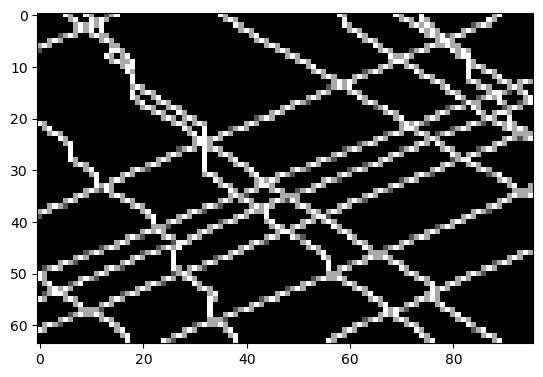

In [85]:
plt.imshow(kymograph_gt, "gray")

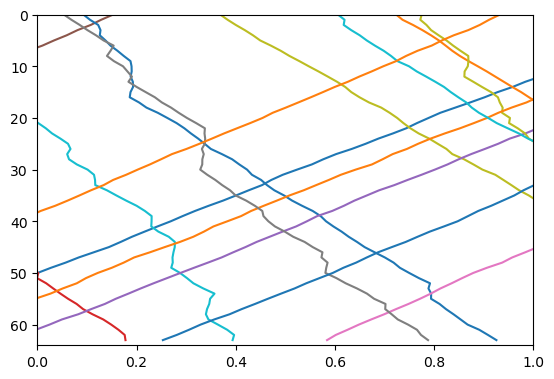

In [83]:
fig, ax = plt.subplots()
for particle_i in range(particle_positions.shape[1]):
    ax.plot(particle_positions[:,particle_i], np.arange(particle_positions.shape[0]))
ax.set_xlim(0, 1)
ax.set_ylim(n_steps, 0)
ax.set_aspect(1 / n_spatial_samples)